<a href="https://colab.research.google.com/github/ariegever/ImageProcessing_Project/blob/main/5_unet_makingraster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install patchify rasterio scikit-image tensorflow earthengine-api
!pip install smooth-tiled-predictions-plus

ERROR: Could not find a version that satisfies the requirement smooth-tiled-predictions-plus (from versions: none)
ERROR: No matching distribution found for smooth-tiled-predictions-plus


In [ ]:
import os
import glob
import gc
import json
import pandas as pd
import time
import numpy as np
import rasterio as rio
from rasterio.windows import Window
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import ImageColor
from keras.models import load_model


In [ ]:
# Trigger the authentication flow.
from google.colab import auth
import google.auth
import ee
auth.authenticate_user()

# Get credentials and initialize Earth Engine
credentials, project = google.auth.default()

# Use your project ID here
EE_PROJECT = 'ivory-scion-476708-t5' # <-- Make sure this is your EE-enabled project
ee.Initialize(credentials, project=EE_PROJECT, opt_url='https://earthengine-highvolume.googleapis.com')

print(f"Successfully initialized Earth Engine for project: {EE_PROJECT}")

Successfully initialized Earth Engine for project: ivory-scion-476708-t5


In [ ]:

# === 1. Project & Year ---
year = 2020

# --- 2. Google Drive Path ---
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images'

# --- 3. File Paths ---
MODEL_PATH = os.path.join(DRIVE_PROJECT_PATH, 'unet_s1_s2_model_v1.keras')
CLASS_JSON_PATH = '/content/drive/MyDrive/Thesis/code/LULC/Unet_model/data/lcs/dict_land_cover.json'

# --- 4. Earth Engine Asset Paths ---
S2_ASSET_PATH = f'projects/ivory-scion-476708-t5/assets/east_negev_Sentinel2_{year}'
S1_ASSET_PATH = f'projects/ivory-scion-476708-t5/assets/east_negev_Sentinel1_{year}'

# --- 5. Export & Prediction Paths ---

# --- THIS IS THE FIX ---
# Earth Engine cannot export to subfolders.
SOURCE_TILE_DIR = os.path.join(DRIVE_PROJECT_PATH, 'prediction')
EXPORT_DRIVE_FOLDER = '/content/drive/MyDrive/GEE_Exports_For_project'
EXPORT_TIF_NAME = f'israel_s1_s2_stack_{year}'
# --- END OF FIX ---

# This is the full path where the script will *look for* the TIF after you move it.
# We are pointing it to the 'prediction' subfolder as you intended.
FULL_TIF_PATH = os.path.join(DRIVE_PROJECT_PATH, 'prediction', f'{EXPORT_TIF_NAME}.tif')

# This is the final classified map
OUTPUT_IMAGE_PATH = os.path.join(DRIVE_PROJECT_PATH, 'prediction', f'LULC_Prediction_Israel_{year}.tif')

# --- 6. Model Parameters (MUST match training) ---
S2_BANDS = [
     'B2', 'B3', 'B4', 'B8', 'B11', 'B12'
]
S1_BANDS = [
    'VV', 'VH'
]
FEATURE_NAMES = S2_BANDS + S1_BANDS
NUM_BANDS = len(FEATURE_NAMES)

print(f"Model: {MODEL_PATH}")
print(f"Class JSON: {CLASS_JSON_PATH}")
print(f"S2 Asset: {S2_ASSET_PATH}")
print(f"S1 Asset: {S1_ASSET_PATH}")
print(f"---")
print(f"EE will export '{EXPORT_TIF_NAME}.tif' to the '{EXPORT_DRIVE_FOLDER}' folder in your Google Drive root.")
print(f"This script will look for the file at: {FULL_TIF_PATH}")
print(f"Will save final LULC map to: {OUTPUT_IMAGE_PATH}")

Model: /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/unet_s1_s2_model_v1.keras
Class JSON: /content/drive/MyDrive/Thesis/code/LULC/Unet_model/data/lcs/dict_land_cover.json
S2 Asset: projects/ivory-scion-476708-t5/assets/east_negev_Sentinel2_2020
S1 Asset: projects/ivory-scion-476708-t5/assets/east_negev_Sentinel1_2020
---
EE will export 'israel_s1_s2_stack_2020.tif' to the '/content/drive/MyDrive/GEE_Exports_For_project' folder in your Google Drive root.
This script will look for the file at: /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/prediction/israel_s1_s2_stack_2020.tif
Will save final LULC map to: /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/prediction/LULC_Prediction_Israel_2020.tif


In [ ]:
# --- 1. Check if the file already exists ---
if os.path.exists(FULL_TIF_PATH):
    print(f"File already exists, skipping export: {FULL_TIF_PATH}")
else:
    print("--- Starting Earth Engine Export ---")

    # --- 2. Load and Stack Assets ---
    try:
        print("Loading EE assets...")
        s2_image = ee.Image(S2_ASSET_PATH).select(S2_BANDS)
        s1_image = ee.Image(S1_ASSET_PATH).select(S1_BANDS)

        ee_image = s2_image.addBands(s1_image).select(FEATURE_NAMES)

        region = ee_image.geometry()
        scale = 10
        crs = ee_image.projection().crs()

        print(f"Image stacked. Total bands: {len(ee_image.bandNames().getInfo())}")

    except Exception as e:
        print(f"Error loading EE assets: {e}")
        print("Please check your ASSET_PATH variables in Cell 5.")
        raise

    # --- 3. Configure and Start Export Task ---
    print("Starting export task to Google Drive...")

    # This code is now correct because the variables from Cell 5 are clean
    task = ee.batch.Export.image.toDrive(
        image=ee_image.toFloat(),
        description=EXPORT_TIF_NAME,  # e.g., "israel_s1_s2_stack_2024"
        folder=EXPORT_DRIVE_FOLDER,   # e.g., "GEE_Exports_For_Thesis"
        fileNamePrefix=EXPORT_TIF_NAME, # e.g., "israel_s1_s2_stack_2024"
        region=region,
        scale=scale,
        crs=crs,
        maxPixels=1e13
    )

    task.start()

    # --- 4. Monitor the Task ---
    print(f"Task started (ID: {task.id}). Monitoring progress...")
    print("This will take 10-20 minutes. Please wait.")

    start_time = time.time()
    while task.active():
        status = task.status()
        elapsed = (time.time() - start_time) / 60
        print(f"  Status: {status['state']}  (Elapsed: {elapsed:.2f} minutes)")
        time.sleep(30) # Check every 30 seconds

    final_status = task.status()
    if final_status['state'] == 'COMPLETED':
        print("--- Export COMPLETED! ---")
        # --- NEW INSTRUCTIONS ---
        print(f"\n!!! ACTION REQUIRED !!!")
        print(f"Earth Engine has saved the file '{EXPORT_TIF_NAME}.tif' to the '{EXPORT_DRIVE_FOLDER}' folder in your Google Drive root.")
        print(f"\nThis script *cannot* find it there. You must *manually* move the file to:")
        print(f"{FULL_TIF_PATH}")
        print("\nAfter you have moved the file, you can run Cell 7.")
        # --- END OF NEW INSTRUCTIONS ---
    else:
        print(f"--- Export FAILED! ---")
        print(f"Error: {final_status['error_message']}")
        raise Exception("Earth Engine export failed. Please check the logs.")

--- Starting Earth Engine Export ---
Loading EE assets...
Image stacked. Total bands: 8
Starting export task to Google Drive...
Task started (ID: GWO3KGHFEYOLIRSWPYH2OR75). Monitoring progress...
This will take 10-20 minutes. Please wait.
  Status: READY  (Elapsed: 0.01 minutes)
  Status: RUNNING  (Elapsed: 0.52 minutes)
  Status: RUNNING  (Elapsed: 1.03 minutes)
  Status: RUNNING  (Elapsed: 1.54 minutes)
  Status: RUNNING  (Elapsed: 2.05 minutes)
  Status: RUNNING  (Elapsed: 2.56 minutes)
  Status: RUNNING  (Elapsed: 3.07 minutes)
--- Export COMPLETED! ---

!!! ACTION REQUIRED !!!
Earth Engine has saved the file 'israel_s1_s2_stack_2020.tif' to the '/content/drive/MyDrive/GEE_Exports_For_project' folder in your Google Drive root.

This script *cannot* find it there. You must *manually* move the file to:
/content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/prediction/israel_s1_s2_stack_2020.tif

After you have moved the file, you can run Cell 7.


In [ ]:
# --- 1. Load the trained model ---
print(f"Loading model from {MODEL_PATH}...")
try:
    model = load_model(MODEL_PATH)
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: Model file not found at {MODEL_PATH}")
    raise
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# --- 2. Load Class Definitions for Colormap ---
print(f"Loading class definitions from {CLASS_JSON_PATH}...")
try:
    with open(CLASS_JSON_PATH) as f:
        lc = json.load(f)
except FileNotFoundError:
    print(f"ERROR: '{CLASS_JSON_PATH}' not found.")
    print("Please check the path in Cell 5.")
    raise

lc_df = pd.DataFrame.from_dict(lc, orient='index')
lc_df = lc_df.rename(columns={'class': 'label', 'color': 'palette'})
lc_df["values_normalize"] = lc_df.index.astype(int) + 1

# Create palette for the final TIF
palette_hex = lc_df["palette"].to_list()
to_values = lc_df["values_normalize"].to_list()
dict_palette = {}
for i in range(len(to_values)):
    dict_palette[to_values[i]] = ImageColor.getrgb(palette_hex[i])

# Create colormap for plotting
cmap = ListedColormap(palette_hex)
vmin = 1
vmax = len(to_values)

print("Model and colormap are ready.")

Loading model from /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/unet_s1_s2_model_v1.keras...
Model loaded successfully.
Loading class definitions from /content/drive/MyDrive/Thesis/code/LULC/Unet_model/data/lcs/dict_land_cover.json...
Model and colormap are ready.


In [ ]:
import numpy as np
import scipy.signal
from tqdm import tqdm
import gc
import cv2

def spline_window_2d(window_size, power=2):
    """
    Generates a 2D window using a Hanning window (standard for image blending).
    This replaces the deprecated bspline function.
    Pixels in the center get weight 1.0, edges get 0.0.
    """
    # Create 1D Hanning window (bell curve)
    # This creates a smooth curve from 0 to 1 to 0
    win_1d = np.hanning(window_size)

    # Create 2D window by multiplying the 1D window with itself (outer product)
    window = np.outer(win_1d, win_1d)

    # Ensure it's normalized to 0-1 range (Hanning already is, but good to be safe)
    window = window / window.max()

    return window

def _pad_img(img, window_size, subdivisions):
    """
    Adds reflection padding to the image so the sliding window
    fits perfectly divisible by the step size.
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    return ret

def _unpad_img(padded_img, window_size, subdivisions):
    """
    Removes the padding added before prediction.
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug : -aug,
        aug : -aug,
        :
    ]
    return ret

def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Apply the `pred_func` (model.predict) using a sliding window with overlap.
    Overlapping predictions are averaged using a weighted window to remove edge artifacts.
    """
    # 1. Pad the image
    pad_img = _pad_img(input_img, window_size, subdivisions)
    pad_img_shape = pad_img.shape

    # 2. Define the step size
    step = int(window_size/subdivisions)

    # 3. Create the weight window
    # Shape: (Window, Window, Classes)
    window_weights = spline_window_2d(window_size)
    window_weights = np.expand_dims(window_weights, axis=-1)
    window_weights = np.tile(window_weights, (1, 1, nb_classes))

    # 4. Initialize prediction buffer and weight buffer
    prediction_probs = np.zeros((pad_img_shape[0], pad_img_shape[1], nb_classes), dtype=float)
    prediction_weights = np.zeros((pad_img_shape[0], pad_img_shape[1], nb_classes), dtype=float)

    # 5. Slide the window
    path_h = range(0, pad_img_shape[0] - window_size + 1, step)
    path_w = range(0, pad_img_shape[1] - window_size + 1, step)

    total_patches = len(path_h) * len(path_w)

    print(f"  - Smooth Windowing: Processing {total_patches} sub-windows...")

    for r in tqdm(path_h, desc="Rows", leave=False):
        for c in path_w:
            # Extract patch
            patch = pad_img[r:r+window_size, c:c+window_size, :]

            # Model expects (Batch, H, W, Bands), so add batch dim
            patch_batch = np.expand_dims(patch, axis=0)

            # PREDICT
            # This calls your lambda function: model.predict(patch)
            pred_batch = pred_func(patch_batch)

            # Remove batch dim -> (H, W, Classes)
            pred_one = pred_batch[0]

            # Add to buffers (Weighted Sum)
            prediction_probs[r:r+window_size, c:c+window_size] += pred_one * window_weights
            prediction_weights[r:r+window_size, c:c+window_size] += window_weights

    # 6. Divide by total weights to get average
    # Avoid division by zero (shouldn't happen due to padding, but safety first)
    prediction_weights[prediction_weights == 0] = 1
    final_prediction = prediction_probs / prediction_weights

    # 7. Unpad to original size
    return _unpad_img(final_prediction, window_size, subdivisions)

In [ ]:
import rasterio as rio
import numpy as np

FILE_PATH = os.path.join(SOURCE_TILE_DIR, f"{EXPORT_TIF_NAME}.tif")

with rio.open(FILE_PATH) as src:
    data = src.read()
    print(f"--- DETECTIVE REPORT FOR: {os.path.basename(FILE_PATH)} ---")
    print(f"Total Bands: {data.shape[0]}")

    # Check every band individualy
    for i in range(data.shape[0]):
        band = data[i]
        # Ignore 0s and NaNs for stats to get the 'real' data range
        valid_pixels = band[~np.isnan(band) & (band != 0)]

        if len(valid_pixels) > 0:
            b_min = valid_pixels.min()
            b_max = valid_pixels.max()
            b_mean = valid_pixels.mean()
            print(f"Band {i}: Min={b_min:.3f}, Max={b_max:.3f}, Mean={b_mean:.3f}")
        else:
            print(f"Band {i}: [EMPTY / ALL ZEROS]")

--- DETECTIVE REPORT FOR: israel_s1_s2_stack_2020.tif ---
Total Bands: 8
Band 0: Min=0.016, Max=1.094, Mean=0.172
Band 1: Min=0.046, Max=1.045, Mean=0.247
Band 2: Min=0.021, Max=1.033, Mean=0.326
Band 3: Min=0.007, Max=1.045, Mean=0.397
Band 4: Min=0.021, Max=0.981, Mean=0.474
Band 5: Min=0.018, Max=0.945, Mean=0.408
Band 6: Min=-23.218, Max=15.554, Mean=-11.617
Band 7: Min=-28.658, Max=3.081, Mean=-20.210


Processing: /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/prediction/israel_s1_s2_stack_2020.tif
Reading window: 3584x3328...
Applying clip (0.0 to 1.0) to match training preprocessing...
Running prediction... (This might take a minute)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Saving prediction to: /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/prediction/LULC_Prediction_2020_Final_Fixed.tif
--- Visual Check ---


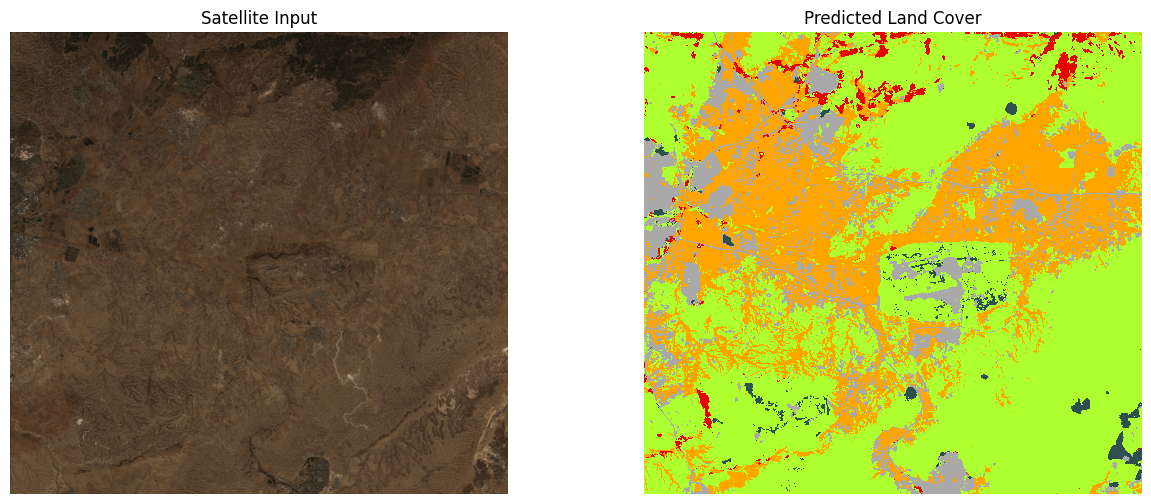

55288

In [ ]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import os
import gc

# --- CONFIGURATION ---
SAT_FILE_PATH = os.path.join(SOURCE_TILE_DIR, f"{EXPORT_TIF_NAME}.tif")
OUTPUT_FILENAME = f"LULC_Prediction_{year}_Final_Fixed.tif"
OUTPUT_PATH = os.path.join(SOURCE_TILE_DIR, OUTPUT_FILENAME)
DIVISIBLE_BY = 128

print(f"Processing: {SAT_FILE_PATH}")

with rio.open(SAT_FILE_PATH) as src:
    # 1. Setup Crop (Divisible by 128)
    full_h, full_w = src.height, src.width
    new_h = (full_h // DIVISIBLE_BY) * DIVISIBLE_BY
    new_w = (full_w // DIVISIBLE_BY) * DIVISIBLE_BY

    # 2. Read Image
    print(f"Reading window: {new_w}x{new_h}...")
    image_data = src.read(window=rio.windows.Window(0, 0, new_w, new_h))

    # --- STEP 1: Handle NaNs (Edges) ---
    image_data = np.nan_to_num(image_data, nan=0.0)

    # --- STEP 2: Match Training Logic (THE FIX) ---
    # Your training code used: tf.clip_by_value(x, 0.0, 1.0)
    # We must do the exact same thing here.
    # This keeps Optical bands as they are (0.1, 0.4, etc.)
    # And forces Radar bands (which are negative) to become 0.0
    print("Applying clip (0.0 to 1.0) to match training preprocessing...")
    input_image = np.clip(image_data, 0.0, 1.0)

    # Transpose for Model: (Bands, H, W) -> (H, W, Bands)
    model_input = np.transpose(input_image, (1, 2, 0))

# 3. Predict
print("Running prediction... (This might take a minute)")
# We add batch dimension: (1, H, W, Bands)
model_input_batch = np.expand_dims(model_input, axis=0)

prediction_probs = model.predict(model_input_batch, verbose=1)

# Get class with highest probability
prediction_map = np.argmax(prediction_probs[0], axis=-1)

# Shift classes +1 (Training was 0-4, output map should be 1-5)
prediction_map = prediction_map + 1

# 4. Save to Disk
print(f"Saving prediction to: {OUTPUT_PATH}")
with rio.open(SAT_FILE_PATH) as src:
    profile = src.profile.copy()
    profile.update(
        dtype=rio.uint8,
        count=1,
        compress='lzw',
        nodata=0,
        width=new_w,
        height=new_h
    )

    with rio.open(OUTPUT_PATH, 'w', **profile) as dst:
        dst.write(prediction_map.astype(rio.uint8), 1)
        if 'dict_palette' in locals():
            dst.write_colormap(1, dict_palette)

# 5. Visual Check
print("--- Visual Check ---")
plt.figure(figsize=(15, 6))

# Plot RGB (Bands 2,1,0 in your stack)
rgb = np.dstack([
    input_image[2], # Red
    input_image[1], # Green
    input_image[0]  # Blue
])
# Re-normalize just for display brightness
rgb = rgb / rgb.max()

plt.subplot(1, 2, 1)
plt.title('Satellite Input')
plt.imshow(rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Predicted Land Cover')
plt.imshow(prediction_map, cmap=cmap, vmin=1, vmax=6, interpolation='nearest')
plt.axis('off')

plt.show()

# Cleanup
del image_data, input_image, model_input, model_input_batch, prediction_probs, prediction_map
gc.collect()

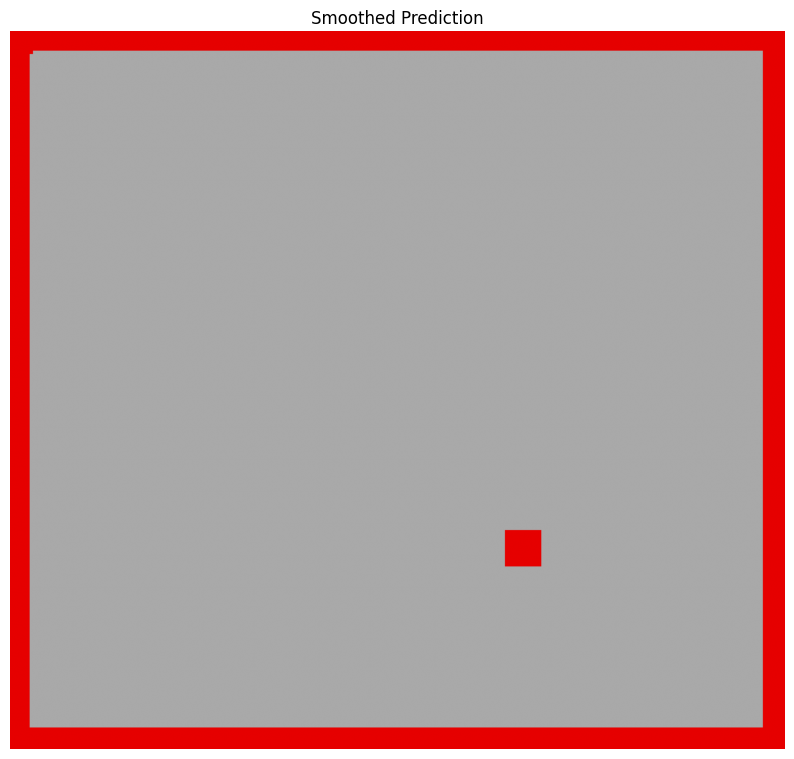

In [ ]:
import rasterio as rio

# --- CONFIGURATION ---
OUTPUT_FILENAME = f"LULC_Prediction_{year}_Visualized_Crop.tif"
OUTPUT_PATH = os.path.join(SOURCE_TILE_DIR, OUTPUT_FILENAME)

print(f"Saving prediction to: {OUTPUT_PATH}")

# We need to re-open the source to get the geospatial metadata (CRS, Transform, etc.)
with rio.open(SAT_FILE_PATH) as src:
    # 1. Create a profile based on the source image
    profile = src.profile.copy()

    # 2. Update the profile to match our prediction output
    # The prediction might be slightly smaller (cropped) than the original,
    # so we must update width/height to match the array we actually have.
    profile.update(
        dtype=rio.uint8,
        count=1,                  # We are saving 1 band (the class map), not 8
        compress='lzw',           # Good compression for maps
        nodata=0,                 # 0 is usually background
        width=prediction_map.shape[1],  # Use the actual width of your prediction
        height=prediction_map.shape[0]  # Use the actual height of your prediction
    )

    # 3. Write the file
    with rio.open(OUTPUT_PATH, 'w', **profile) as dst:
        dst.write(prediction_map.astype(rio.uint8), 1)

        # 4. Apply the Color Palette (so it opens with colors in QGIS/ArcGIS)
        # This uses the 'dict_palette' you created earlier from the JSON file
        if 'dict_palette' in locals():
            print("Applying color palette to GeoTIFF...")
            dst.write_colormap(1, dict_palette)
        else:
            print("Warning: 'dict_palette' not found. File saved without embedded colors.")

print("Successfully saved!")